In [1]:
#The IRS Migration DB only includes filers who were matched between 2 consecutive years
#This script compares the total number of filers who filed in a year from a separate IRS report
#to the number of matched filers in the database and calculates coverage rates for NYC and NY Metro

%matplotlib inline
import pandas as pd
import sqlite3
import os
import matplotlib
matplotlib.style.use('ggplot')

data_path='/home/franknitty/irs_nyc_migration/data/'
data_base='irsmig_county_database/irs_migration_county.sqlite'
sqldb=os.path.join(data_path,data_base)

data_csv=os.path.join(data_path,'total_filers/totfilers_nymetro.csv')

nyc=('36005','36047','36061','36081','36085')
nyma=('34003','34013','34017','34019','34023','34025','34027','34029','34031',\
      '34035','34037','34039','36005','36027','36047','36059','36061','36071',\
      '36079','36081','36085','36087','36103','36119','42103')

years=['2011_12','2012_13','2013_14','2014_15']

/home/franknitty/.local/lib/python3.5/site-packages/pandas/core/computation/__init__.py:18: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [2]:
#Get sum of filers in the migration db for NY metro by grouping non-movers and in-migrants
con=sqlite3.connect(sqldb)
df_nymetmig = pd.DataFrame()

for year in years:
    tab='inflow_{}'.format(year)
    mtotal = pd.read_sql_query('SELECT "{}" AS year, destination AS fips, \
    sum(returns) AS returns,sum(exemptions) AS exemptions \
    FROM {} where destination in {} GROUP BY destination'.format(year,tab,nyma),con)
    df_nymetmig=df_nymetmig.append(mtotal,ignore_index=True)
    
con.close()
df_nymetmig.head()

,year,fips,returns,exemptions
0,2011_12,34003,371057,807049
1,2011_12,34013,295175,626910
2,2011_12,34017,263118,503759
3,2011_12,34019,51835,116546
4,2011_12,34023,324297,720522


In [3]:
#Get total number of all filers from IRS repport csv

df_totalfiler=pd.read_csv((data_csv),converters={'fips':str})
df_totalfiler.head()

,fips,cname,state,year,returns,exempt
0,34003,Bergen County,NJ,2011_12,454847,883358
1,34013,Essex County,NJ,2011_12,370610,711281
2,34017,Hudson County,NJ,2011_12,318912,569669
3,34019,Hunterdon County,NJ,2011_12,63949,125713
4,34023,Middlesex County,NJ,2011_12,397633,794769


In [4]:
#Join the two tables together
joined=pd.merge(df_totalfiler, df_nymetmig, on=['fips','year'])
joined.rename(columns={'returns_x':'totreturns','exempt':'totexempts',
                       'returns_y':'migreturns','exemptions':'migexempts'},inplace=True)

joined.head()

,fips,cname,state,year,totreturns,totexempts,migreturns,migexempts
0,34003,Bergen County,NJ,2011_12,454847,883358,371057,807049
1,34013,Essex County,NJ,2011_12,370610,711281,295175,626910
2,34017,Hudson County,NJ,2011_12,318912,569669,263118,503759
3,34019,Hunterdon County,NJ,2011_12,63949,125713,51835,116546
4,34023,Middlesex County,NJ,2011_12,397633,794769,324297,720522


In [5]:
#Generate summaries and calculate percentages for the NY metro area
nyma_matched=joined[['year','migreturns','totreturns','migexempts','totexempts']].groupby(['year']).sum().reset_index()
nyma_matched['pct_returns']=((nyma_matched.migreturns / nyma_matched.totreturns)*100).round(1)
nyma_matched['pct_exempts']=((nyma_matched.migexempts / nyma_matched.totexempts)*100).round(1)

nyma_matched.head()

,year,migreturns,totreturns,migexempts,totexempts,pct_returns,pct_exempts
0,2011_12,7854894,9649845,16319438,18261286,81.4,89.4
1,2012_13,7874702,9631280,16343986,18214220,81.8,89.7
2,2013_14,7909760,9733350,16356436,18312880,81.3,89.3
3,2014_15,8013002,9822750,16427579,18346980,81.6,89.5


In [6]:
#Generate summaries and calculate percentages for the NYC
nyc_matched=joined[joined['fips'].isin(nyc)][['year','migreturns','totreturns','migexempts','totexempts']].groupby(['year']).sum().reset_index()
nyc_matched['pct_returns']=((nyc_matched.migreturns / nyc_matched.totreturns)*100).round(1)
nyc_matched['pct_exempts']=((nyc_matched.migexempts / nyc_matched.totexempts)*100).round(1)

nyc_matched.head()

,year,migreturns,totreturns,migexempts,totexempts,pct_returns,pct_exempts
0,2011_12,3263045,3993358,6345178,7255391,81.7,87.5
1,2012_13,3272696,3974160,6370755,7247540,82.3,87.9
2,2013_14,3297686,4030410,6402397,7318410,81.8,87.5
3,2014_15,3364504,4089180,6485295,7381290,82.3,87.9


In [7]:
#LaTeX example NYC table
print(nyc_matched.to_latex())

\begin{tabular}{llrrrrrr}
\toprule
{} &     year &  migreturns &  totreturns &  migexempts &  totexempts &  pct\_returns &  pct\_exempts \\
\midrule
0 &  2011\_12 &     3263045 &     3993358 &     6345178 &     7255391 &         81.7 &         87.5 \\
1 &  2012\_13 &     3272696 &     3974160 &     6370755 &     7247540 &         82.3 &         87.9 \\
2 &  2013\_14 &     3297686 &     4030410 &     6402397 &     7318410 &         81.8 &         87.5 \\
3 &  2014\_15 &     3364504 &     4089180 &     6485295 &     7381290 &         82.3 &         87.9 \\
\bottomrule
\end{tabular}



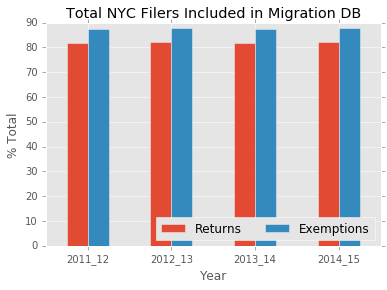

In [8]:
#Figure example NYC plot
bchart=pd.DataFrame(nyc_matched.set_index(['year']), columns=['pct_returns','pct_exempts'])
my_plot = bchart.plot(kind='bar',title="Total NYC Filers Included in Migration DB",rot=0)
my_plot.set_xlabel("Year")
my_plot.set_ylabel("% Total")
my_plot.legend(["Returns","Exemptions"], loc=4,ncol=2)

fig = my_plot.get_figure()
fig.savefig('test_figure.png')